In [1]:
%load_ext autoreload
%autoreload 2

### I. Identify the device and region on which to measure volume

<div>
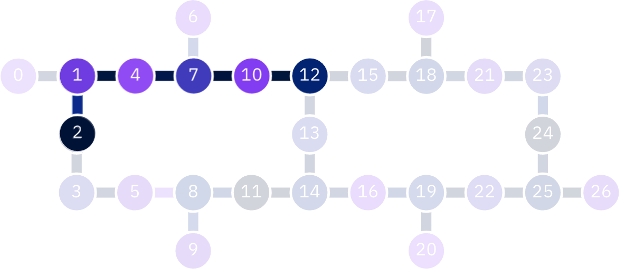
</div>

In [2]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.providers(hub='ibm-q-internal', group='performance', project='default-params')[0]
backend = provider.backend.ibm_hanoi

In [19]:
from qiskit.transpiler import InstructionDurations, CouplingMap

qubit_subset = [2, 1, 4, 7, 10, 12]

coupling_map = CouplingMap(backend.configuration().coupling_map)
basis_gates = backend.configuration().basis_gates
dt = backend.configuration().dt

instruction_durations = InstructionDurations.from_backend(backend)
synthesis_fidelity = .99

optimize_orientation = True

### II. Load pre-mapped circuits

If you do not have access to a full CPLEX license or if you want to speed up the compilation process, you can load pre-mapped circuits and set `do_mapping=False` below. If you are using the same qubit connecitivity topology, this can be a good way to skip the CPLEX optimization part of compilation, since the mapping problem is dependent only on the topology. Setting `do_mapping=True` will do the entire compilation flow in Qiskit.

In [4]:
do_mapping = False

In [5]:
from qiskit.circuit import qpy_serialization
with open('premapped/qv64_original.qpy', 'rb') as f:
    model_circuits = qpy_serialization.load(f)
with open('premapped/qv64_bip_line_approx99.qpy', 'rb') as f:
    model_circuits_mapped = qpy_serialization.load(f)

### III. Build a custom passmanager that will do the desired circuit mapping and optimizations

In [6]:
# a custom passmanager that does the compilation of QV circuits
import numpy as np
from qiskit.circuit import QuantumRegister
from qiskit.circuit.library import XGate, RZGate
from qiskit.transpiler import PassManager, Layout
from qiskit.transpiler.passes import (BIPMapping,
                                      Depth, 
                                      FixedPoint,
                                      Collect2qBlocks, 
                                      ConsolidateBlocks,
                                      UnitarySynthesis, 
                                      Optimize1qGatesDecomposition, 
                                      CommutativeCancellation, 
                                      SetLayout, 
                                      FullAncillaAllocation, 
                                      EnlargeWithAncilla, 
                                      ApplyLayout,
                                      ALAPSchedule,
                                      DynamicalDecoupling)

def qv_passmanager(basis_gates, coupling_map, qubit_subset, backend_props,
                   instruction_durations, synthesis_fidelity=1., pulse_optimize=True, do_mapping=False):
    
    def _repeat_condition(property_set):
        return not property_set['depth_fixed_point']

    qr = QuantumRegister(size=len(qubit_subset), name='q')
    layout = Layout.from_intlist(qubit_subset, qr)

    _map = [BIPMapping(coupling_map, qubit_subset=qubit_subset, objective='balanced', time_limit=100, backend_prop=backend_props)]

    _embed = [SetLayout(layout),
              FullAncillaAllocation(coupling_map),
              EnlargeWithAncilla(),
              ApplyLayout()]

    _check_depth = [Depth(),
                    FixedPoint('depth')]

    _optimize = [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates),
        UnitarySynthesis(basis_gates, synthesis_fidelity, coupling_map, backend_props,
                         pulse_optimize=True, natural_direction=True),
        Optimize1qGatesDecomposition(basis_gates)
    ]

    _schedule = [
        ALAPSchedule(instruction_durations),
        DynamicalDecoupling(instruction_durations,
                            dd_sequence=[XGate(), XGate()],
                            qubits=[3, 2, 1, 7, 10]),
        DynamicalDecoupling(instruction_durations,
                            dd_sequence=[XGate(), RZGate(np.pi), XGate()] * 2,
                            qubits=[4], spacing=[1/8, 1/4, 0, 1/4, 1/4, 0,  1/8])
    ]

    pm = PassManager()
    if do_mapping:
        pm.append(_map)                     # map to a subset of qubits, by choosing layout and inserting swaps
    else:
        pm.append(_embed)                   # embed the mapped circuit onto the larger device coupling map
    pm.append(_check_depth + _optimize,
              do_while=_repeat_condition)  # translate to & optimize over hardware native gates
    pm.append(_schedule)                   # dynamical decoupling on an as-late-as-possible schedule
    return pm

In [7]:
pm = qv_passmanager(basis_gates=basis_gates,
                    coupling_map=coupling_map,
                    qubit_subset=qubit_subset,
                    backend_props=backend.properties(),
                    instruction_durations=instruction_durations,
                    synthesis_fidelity=synthesis_fidelity,
                    pulse_optimize=True,
                    do_mapping=do_mapping)

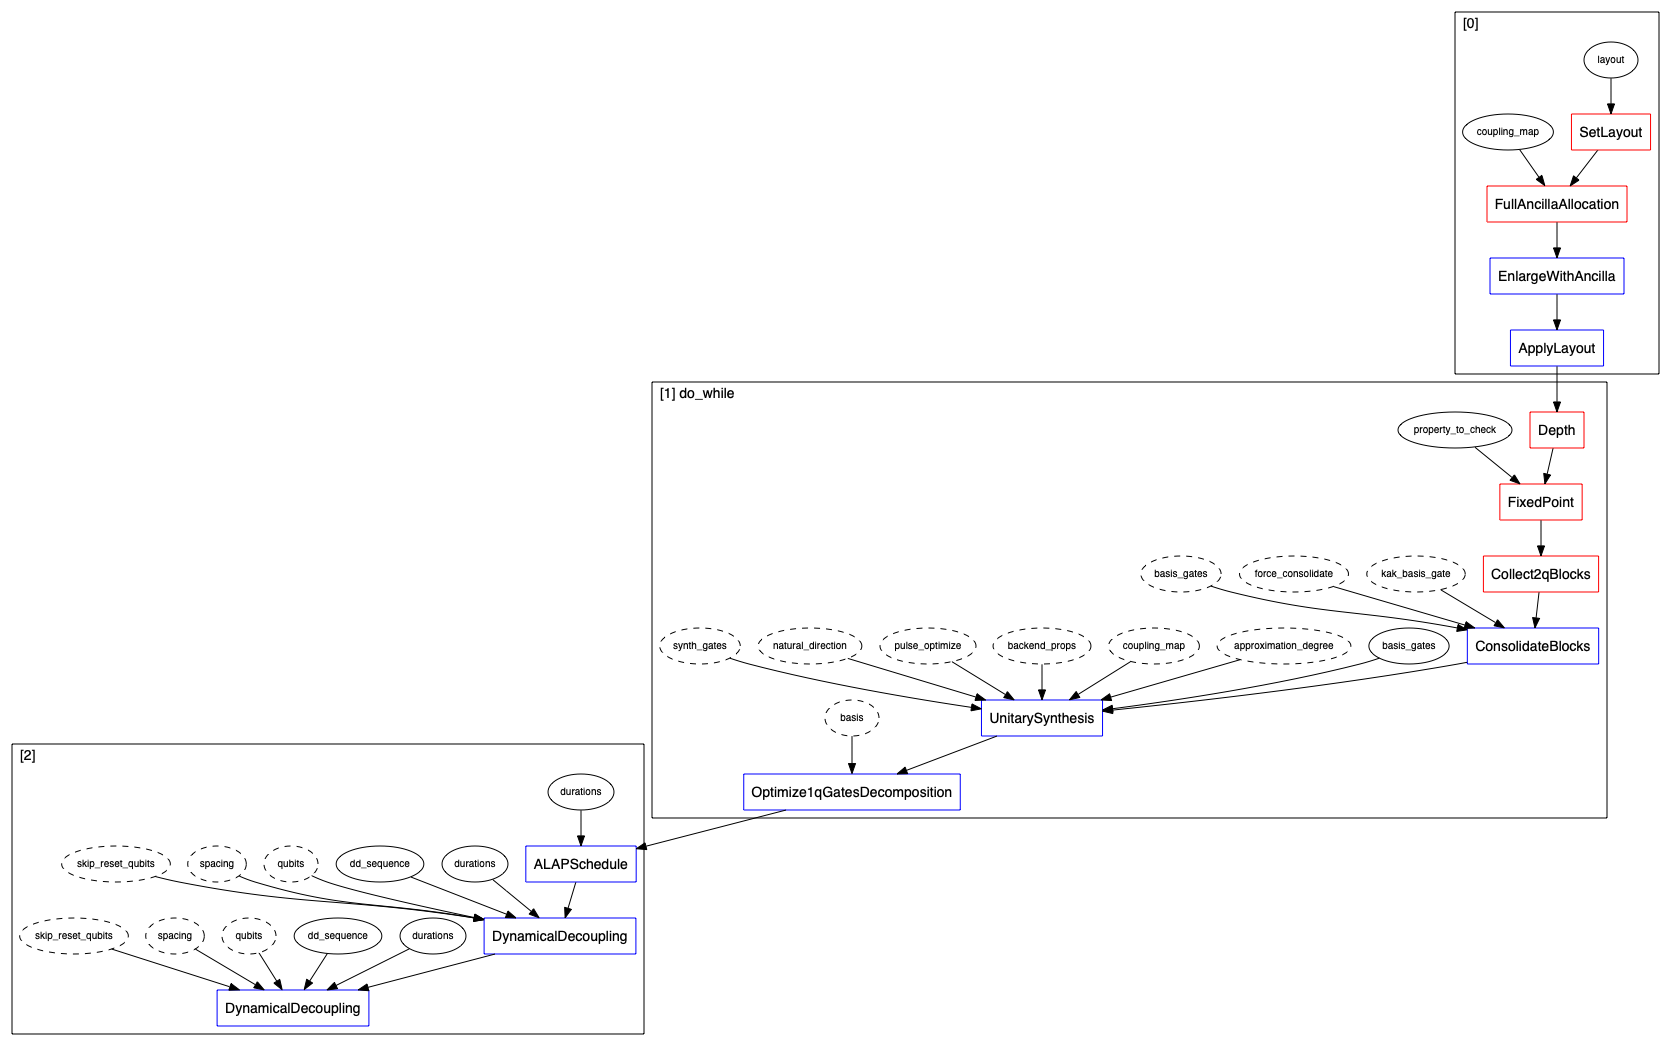

In [8]:
# optional: visualize the passmanager to see the passes invoked
pm.draw()

### IV. Compile 100 model circuits and plot distribution of resources

In [14]:
import qv_tools as tools

N = 2000

In [10]:
from qiskit.circuit.library import QuantumVolume

# build fresh quantum volume model circuits if not using pre-mapped circuits
if do_mapping:
    model_circuits = [QuantumVolume(num_qubits=len(qubit_subset), seed=i).decompose() for i in range(N)]
    model_circuits_measured = [circuit.measure_all(inplace=False) for circuit in model_circuits]

In [11]:
from tqdm import tqdm

model_circuits_compiled = []

if do_mapping:
    for circuit in tqdm(model_circuits_measured):
        model_circuits_compiled.append(pm.run(circuit))
else:
    for circuit in tqdm(model_circuits_mapped[:N]):
        model_circuits_compiled.append(pm.run(circuit))

100%|██████████| 2000/2000 [17:15<00:00,  1.93it/s]


### V. Optional: Tailor circuit orientation around topology's symmetry point

This part increases compilation time, so you may skip it by setting `optimize_orientation = False` above. 
But it has the potential to reduce the average circuit duration by checking the best layout of the circuit about the point of symmetry of the coupling map. So for a line, it checks whether left-to-right or right-to-left layout has lower duration for each circuit.

In [12]:
if optimize_orientation:
    orientation_circuits = [model_circuits_compiled]

    other_orientations = [list(reversed(qubit_subset))]

    for orientation in other_orientations:
        pm = qv_passmanager(basis_gates=basis_gates,
                            coupling_map=coupling_map,
                            qubit_subset=orientation,
                            backend_props=backend.properties(),
                            instruction_durations=instruction_durations,
                            synthesis_fidelity=synthesis_fidelity,
                            pulse_optimize=True,
                            do_mapping=False)

        circuits_compiled_one_orientation = []
        if do_mapping:
            for circuit in tqdm(model_circuits_measured):
                circuits_compiled_one_orientation.append(pm.run(circuit))
        else:
            for circuit in tqdm(model_circuits_mapped[:N]):
                circuits_compiled_one_orientation.append(pm.run(circuit))

        orientation_circuits.append(circuits_compiled_one_orientation)

        candidate_durations = []
        for circs in orientation_circuits:
            candidate_durations.append(tools.get_qubit_durations(circs, qubit_subset, backend))
            
        model_circuits_compiled_bestof = tools.pick_best_circuits_for_duration(backend, 
                                                                               orientation_circuits, 
                                                                               candidate_durations)
        
        model_circuits_compiled = model_circuits_compiled_bestof

100%|██████████| 2000/2000 [17:58<00:00,  1.85it/s]


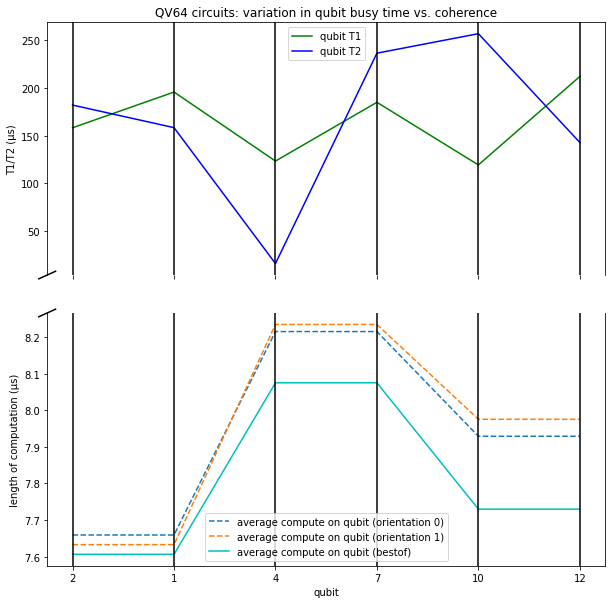

In [20]:
if optimize_orientation:
    tools.plot_improvement_duration(backend, candidate_durations, sample_circuit=None, metric='average')

### VI. Run experiments and compute HOPs

You can split the circuits into multiple jobs by setting `num_jobs` below.

array([<AxesSubplot:title={'center':'cx\nmean: 57.5    median: 58.0\nmin: 26     max: 78'}>,
       <AxesSubplot:title={'center':'sx\nmean: 146.0    median: 144.0\nmin: 78     max: 180'}>,
       <AxesSubplot:title={'center':'duration\nmean: 8138.9    median: 8426.0\nmin: 4213     max: 9514'}>],
      dtype=object)

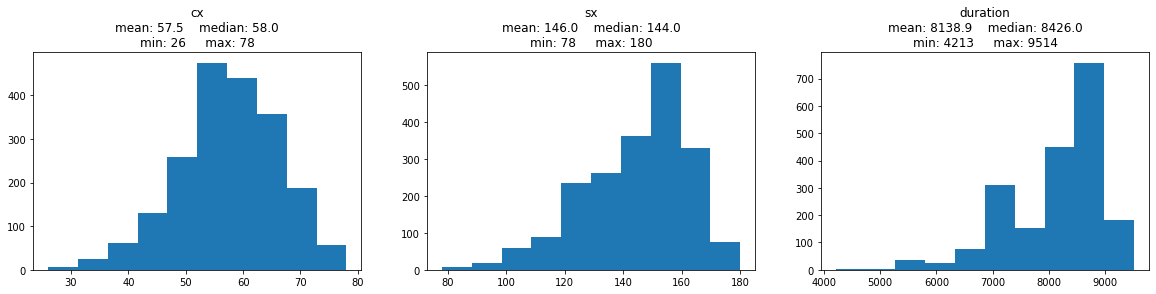

In [21]:
# get statistics on cost of circuits that will be submitted
tools.plot_resources(model_circuits_compiled, dt)

In [22]:
from qiskit.providers.aer import AerSimulator
fake_backend = AerSimulator()

In [44]:
import qiskit.tools.jupyter
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [40]:
shots = 2000
num_jobs = 4
batches = [model_circuits_compiled[i*int(N/num_jobs):(i+1)*int(N/num_jobs)] for i in range(num_jobs)]
jobs_exp = [backend.run(batch, shots=shots) for batch in batches]
job_sim = fake_backend.run([tools.remove_delay(c) for c in model_circuits_compiled], shots=shots)

In [54]:
hops_exp = []
hops_sim = []

counts_exp_list = []
counts_sim_list = []

res_sim = job_sim.result()
for batch, job_exp in zip(batches, jobs_exp):
    res_exp = job_exp.result()
    for c in batch:
        counts_exp_list.append(res_exp.get_counts(c))
        counts_sim_list.append(res_sim.get_counts(c))

for model_circuit, counts_exp, counts_sim in zip(model_circuits, counts_exp_list, counts_sim_list):
    ideal_probs = tools.get_ideal_probabilities(model_circuit)
    median, heavy_strings = tools.get_heavy_strings(ideal_probs)

    hops_exp.append(tools.hop(counts_exp, ideal_probs))
    hops_sim.append(tools.hop(counts_sim, ideal_probs))

0.6315189453977813


<AxesSubplot:title={'center':'mean hop: 0.65\n±2σ: [0.632, 0.674]\nsuccess: False'}, xlabel='Number of Trials', ylabel='Heavy Output Probability'>

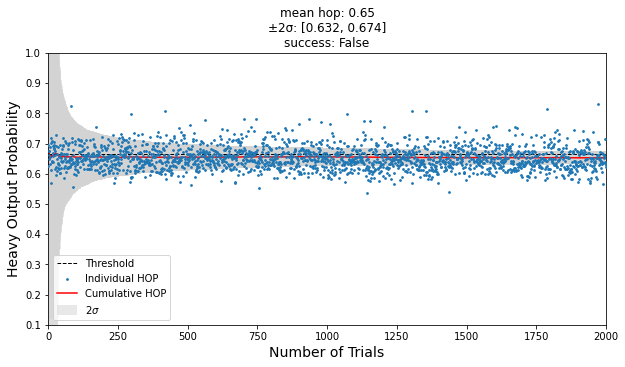

In [55]:
# HOP from experiment
tools.plot_hop_accumulative(hops_exp)

0.825184017772236


<AxesSubplot:title={'center':'mean hop: 0.84\n±2σ: [0.825, 0.858]\nsuccess: True'}, xlabel='Number of Trials', ylabel='Heavy Output Probability'>

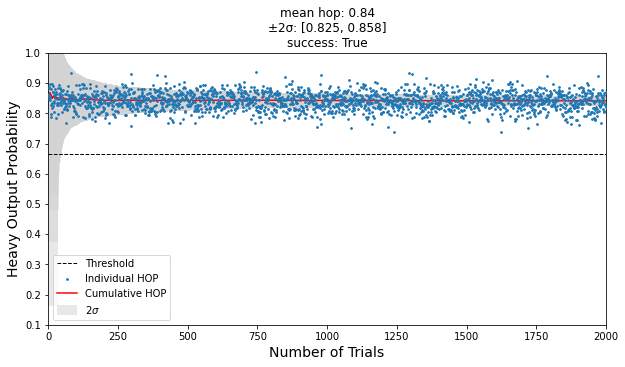

In [56]:
# HOP from ideal simulation
tools.plot_hop_accumulative(hops_sim)

### VII. Optional: Analysis of individual circuits and statistics

In [57]:
cx_counts = [c.count_ops().get('cx', 0) for c in model_circuits_compiled]
sx_counts = [c.count_ops().get('sx', 0) for c in model_circuits_compiled]
x_counts = [c.count_ops().get('x', 0) for c in model_circuits_compiled]
depths = [c.depth() for c in model_circuits_compiled]
durations = [c.duration * dt * 1e6 for c in model_circuits_compiled]

Text(0.5, 0, 'hop sim')

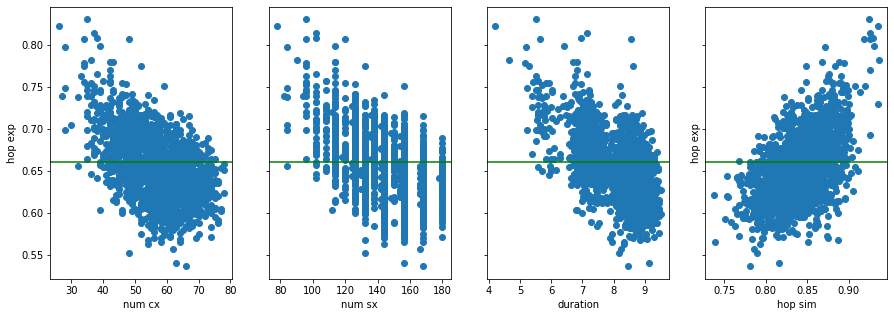

In [58]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(15, 5))
ax[0].scatter(cx_counts, hops_exp)
ax[0].axhline(0.66, color='g')
ax[0].set_xlabel('num cx')
ax[0].set_ylabel('hop exp')

ax[1].scatter(sx_counts, hops_exp)
ax[1].axhline(0.66, color='g')
ax[1].set_xlabel('num sx')

ax[2].scatter(durations, hops_exp)
ax[2].axhline(0.66, color='g')
ax[2].set_xlabel('duration')

ax[3].scatter(hops_sim, hops_exp)
ax[3].axhline(0.66, color='g')
ax[3].set_ylabel('hop exp')
ax[3].set_xlabel('hop sim')

In [59]:
i = 0
model_circuit = model_circuits[i]
model_circuit_mapped = model_circuits_mapped[i]
model_circuit_compiled = model_circuits_compiled[i]
print(f"num cx: ", cx_counts[i])
print(f"num sx: ", sx_counts[i])
print(f"num x: ", x_counts[i])
print(f"depth: ", depths[i])
print(f"duration: ", durations[i], " us")
print(f"hop exp: ", hops_exp[i])
print(f"hop sim: ", hops_sim[i])

num cx:  62
num sx:  156
num x:  28
depth:  155
duration:  8.597333333333333  us
hop exp:  0.627
hop sim:  0.8585


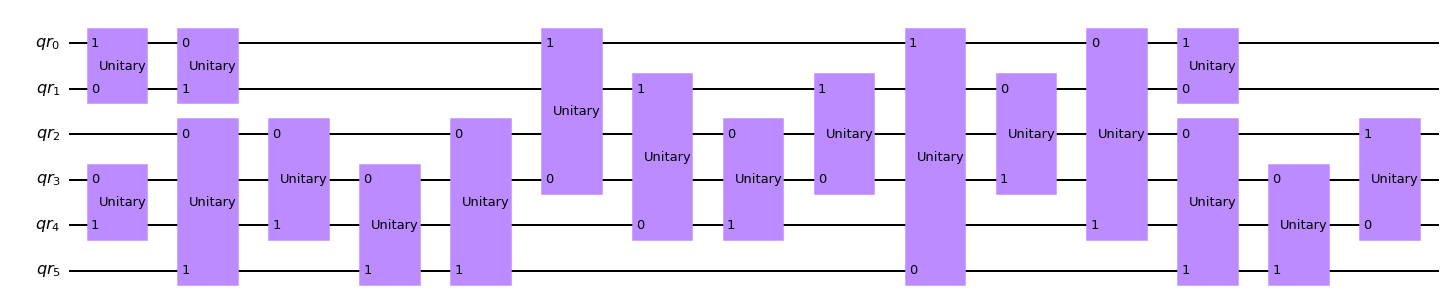

In [60]:
model_circuit.draw('mpl', fold=-1)

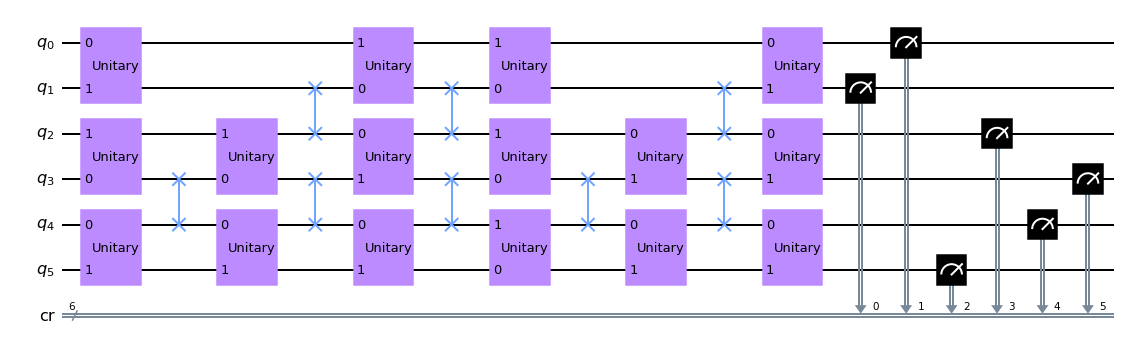

In [61]:
model_circuit_mapped.draw('mpl', fold=-1)

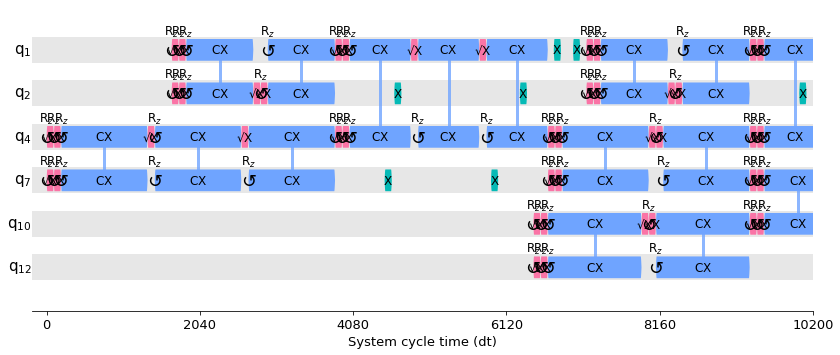

In [62]:
from qiskit.visualization import timeline_drawer
timeline_drawer(model_circuit_compiled, time_range=(0, 10000), show_idle=False)

In [63]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright